In [21]:
import os

import pymc as pm
import pandas as pd
import numpy as np
import pickle
import cloudpickle
import gzip
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import cobra
sns.set(context="talk", style="ticks", color_codes=True, rc={"legend.frameon": False})

%matplotlib inline

In [22]:
os.getcwd()

'/Users/mahs128/Repos/syn_bmca/src'

In [24]:
syn_model_fname = "../models/iJB785_no_zero_flux_flipped.xml"
syn_model =cobra.io.read_sbml_model(syn_model_fname)


Set parameter TokenServer to value "leghorn.emsl.pnl.gov"


In [25]:
with gzip.open("Syn_80k.pgz", "rb") as f:
    advi_results = cloudpickle.load(f)

In [26]:
with gzip.open("Syn_pymcmodel_data.pgz", "rb") as f:
    pymc_data = cloudpickle.load(f)

In [27]:
pymc_data.keys()

dict_keys(['model', 'en', 'xn', 'x_inds', 'e_inds', 'll', 'v_star'])

In [28]:
dir(advi_results['model'])

['Ex',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_config_context',
 '_context_class',
 '_coords',
 '_dim_lengths',
 '_parent',
 '_pytensor_config',
 '_repr_latex_',
 '_validate_name',
 'add_coord',
 'add_coords',
 'add_named_variable',
 'basic_RVs',
 'check_bounds',
 'check_start_vals',
 'chi_obs',
 'chi_ss',
 'compile_d2logp',
 'compile_dlogp',
 'compile_fn',
 'compile_logp',
 'contexts',
 'continuous_value_vars',
 'coords',
 'create_value_var',
 'd2logp',
 'datalogp',
 'debug',
 'deterministics',
 'dim_lengths',
 'discrete_value_vars',
 'dlogp',
 'eval_rv_shapes',
 'e

In [29]:
advi_results['model'].model

/Users/mahs128/.pyenv/versions/3.11.5/envs/bmca/lib/python3.11/site-packages/pymc/model/core.py:568: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)


 ex_kinetic_entries ~ HalfNormal(0, 1)
ex_capacity_entries ~ Laplace(0, 0.01)
     log_e_measured ~ Normal(<constant>, 0.2)
   log_e_unmeasured ~ Laplace(0, 0.1)
               yn_t ~ Normal(0, 10)
                 Ex ~ Deterministic(f(ex_capacity_entries, ex_kinetic_entries))
           log_en_t ~ Deterministic(f(log_e_unmeasured, log_e_measured))
             chi_ss ~ Deterministic(f(yn_t, log_e_unmeasured, log_e_measured, ex_capacity_entries, ex_kinetic_entries))
            chi_obs ~ Normal(f(yn_t, log_e_unmeasured, log_e_measured, ex_capacity_entries, ex_kinetic_entries), 0.2)

In [38]:
trace = advi_results['hist'].sample(200)

In [52]:
trace

Inference data with groups:
	> posterior
	> observed_data

In [54]:
trace_post_Ex = trace.posterior['Ex'][0].to_numpy()
trace_post_Ex.shape

(200, 570, 769)

## Make FCC box plots

In [36]:
ll = pymc_data['ll']
ll

In [59]:
r_labels = [r.id for r in syn_model.reactions]
target_rxn = 'SUCRt2'

In [60]:


fcc = pd.DataFrame(
    np.array(
        [
            ll.flux_control_coefficient(Ex=ex)[r_labels.index(target_rxn)]
            for ex in tqdm(trace.posterior['Ex'][0].to_numpy())
        ]
    ),
    columns=r_labels,
)

100%|██████████| 200/200 [07:53<00:00,  2.37s/it]


In [61]:
fcc

,EX_hco3_e,ADPT,O2tcx,AOXPBDC,DNTPPA,BIOMASS_PIGMENTS,H2Otu_syn,DTMPK,BIOMASS__1,ACOATA,...,ATPSum,CYSDES,NO3abcpp,GLNS,THII,SHS1,PSIICSum,ASNS1,EX_sucr_e,SUCRt2
0,0.318048,-0.000355,0.000269,-0.000050,-0.000582,0.000509,-0.000148,0.000410,-0.000131,0.000678,...,0.005471,-0.001199,0.001183,-0.000091,-0.000797,-0.000188,-0.000430,0.001385,0.290486,0.644343
1,-0.070924,0.001250,-0.000463,0.000246,0.000198,0.000182,0.004161,0.000410,-0.000071,0.001109,...,0.001536,-0.000200,-0.003095,-0.000811,-0.000177,0.000021,0.000022,-0.000893,0.569417,0.396752
2,-0.030190,-0.000115,0.001553,0.000456,-0.000207,-0.000217,0.000145,0.000324,-0.000554,0.001189,...,0.002666,0.000242,-0.002136,0.000017,0.000243,-0.000071,0.000224,-0.000036,0.466918,0.513948
3,0.089410,0.000872,-0.000089,0.000313,0.003202,0.000598,-0.002850,-0.001033,0.000211,0.000199,...,0.003667,0.000657,-0.000301,-0.003134,0.000080,-0.000060,-0.000074,0.000437,0.436357,0.515483
4,0.107375,0.000599,0.000803,0.000930,-0.000127,0.000069,-0.000943,0.001294,0.000155,0.000012,...,0.001601,0.000146,-0.000180,-0.000458,-0.000652,-0.000078,0.000135,0.000848,0.625800,0.347828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.059987,0.000036,-0.000420,-0.000195,-0.000266,0.000092,0.000275,0.000167,-0.000011,0.000944,...,0.000211,0.001275,0.000101,-0.002447,0.000194,-0.000075,-0.000049,-0.000106,0.773037,0.214147
196,0.099603,-0.000424,0.000427,-0.001381,0.000272,-0.000124,-0.001738,0.000913,-0.000111,0.000443,...,0.003621,-0.000178,0.000245,0.002077,-0.000481,-0.000057,-0.000149,-0.000552,0.507837,0.455155
197,0.398221,-0.000144,0.000132,-0.002584,0.001191,0.000767,0.004498,-0.002195,-0.000204,-0.000830,...,0.013280,0.001331,-0.001010,-0.002011,0.000194,-0.000247,-0.001109,0.001623,0.387721,0.504827
198,0.142024,0.000634,-0.001195,0.001478,0.001710,0.000249,0.000722,0.000206,-0.000191,-0.002104,...,0.002951,0.000287,-0.004022,-0.001526,-0.000003,-0.000200,0.000342,0.002176,0.488441,0.497621


In [62]:
fcc_sort = fcc.reindex(columns=fcc.median().sort_values().index)
# fcc_prior_sort = fcc_prior.reindex(columns=fcc.median().sort_values().index)

# Calculate the fcc values that have 95% Highest Posterior Densities with a consistent direction.
hdi = pm.hdi(fcc_sort.values)
# hpd_prior = pm.hpd(fcc_prior_sort.values)

fcc_consistent = np.sign(hdi[:, 0]) == np.sign(hdi[:, 1])


/var/folders/k9/b8pxky2572sdtgy2vnxhcljw0000gn/T/ipykernel_63395/2829467274.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pm.hdi(fcc_sort.values)


In [76]:
sum(fcc_consistent)

5

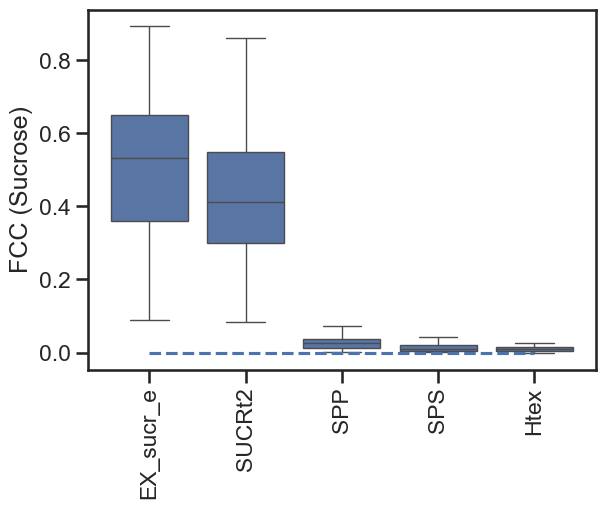

In [78]:
sns.boxplot(
    x="variable",
    y="value",
    data=fcc_sort.loc[:, fcc_consistent].melt(),
    order=fcc_sort.loc[:, fcc_consistent]
    .median()
    .abs()
    .sort_values(ascending=False)
    .index[:sum(fcc_consistent)],
    fliersize=0,
)
plt.tight_layout()
plt.hlines([0], 0, (sum(fcc_consistent)-1), linestyles="dashed")
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel("FCC (Sucrose)")
plt.savefig("Syn_fcc_sucrose_sorted.svg", dpi=300, bbox_inches="tight")
plt.savefig("Syn_fcc_sucrose_sorted.png", dpi=300, bbox_inches="tight")


fccs = fcc.to_numpy(dtype="float")
fccs



# Initialize an empty array to store HDI results
fccs_hdi = np.zeros((240, 240, 2))

# Calculate HDI for each slice along the first dimension
for i in range(fccs.shape[1]):
    for j in range(fccs.shape[2]):
        hdi = pm.hdi(fccs[:, i, j])  # Compute HDI for each element (across the 500 dimension)
        fccs_hdi[i, j] = hdi  # Store HDI results
fcc_consistent = np.sign(fccs_hdi[:, :, 0]) == np.sign(fccs_hdi[:, :, 1])


In [ ]:

# Calculate the fcc values that have 95% Highest Posterior Densities with a consistent direction.
hdi = pm.hdi(fcc_sort.values)
# hpd_prior = pm.hpd(fcc_prior_sort.values)

fcc_consistent = np.sign(hdi[:, 0]) == np.sign(hdi[:, 1])